## Imports

In [19]:
from time_series_generation import *
from phid import *
from network_analysis import *
from hf_token import TOKEN

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load the Time Series

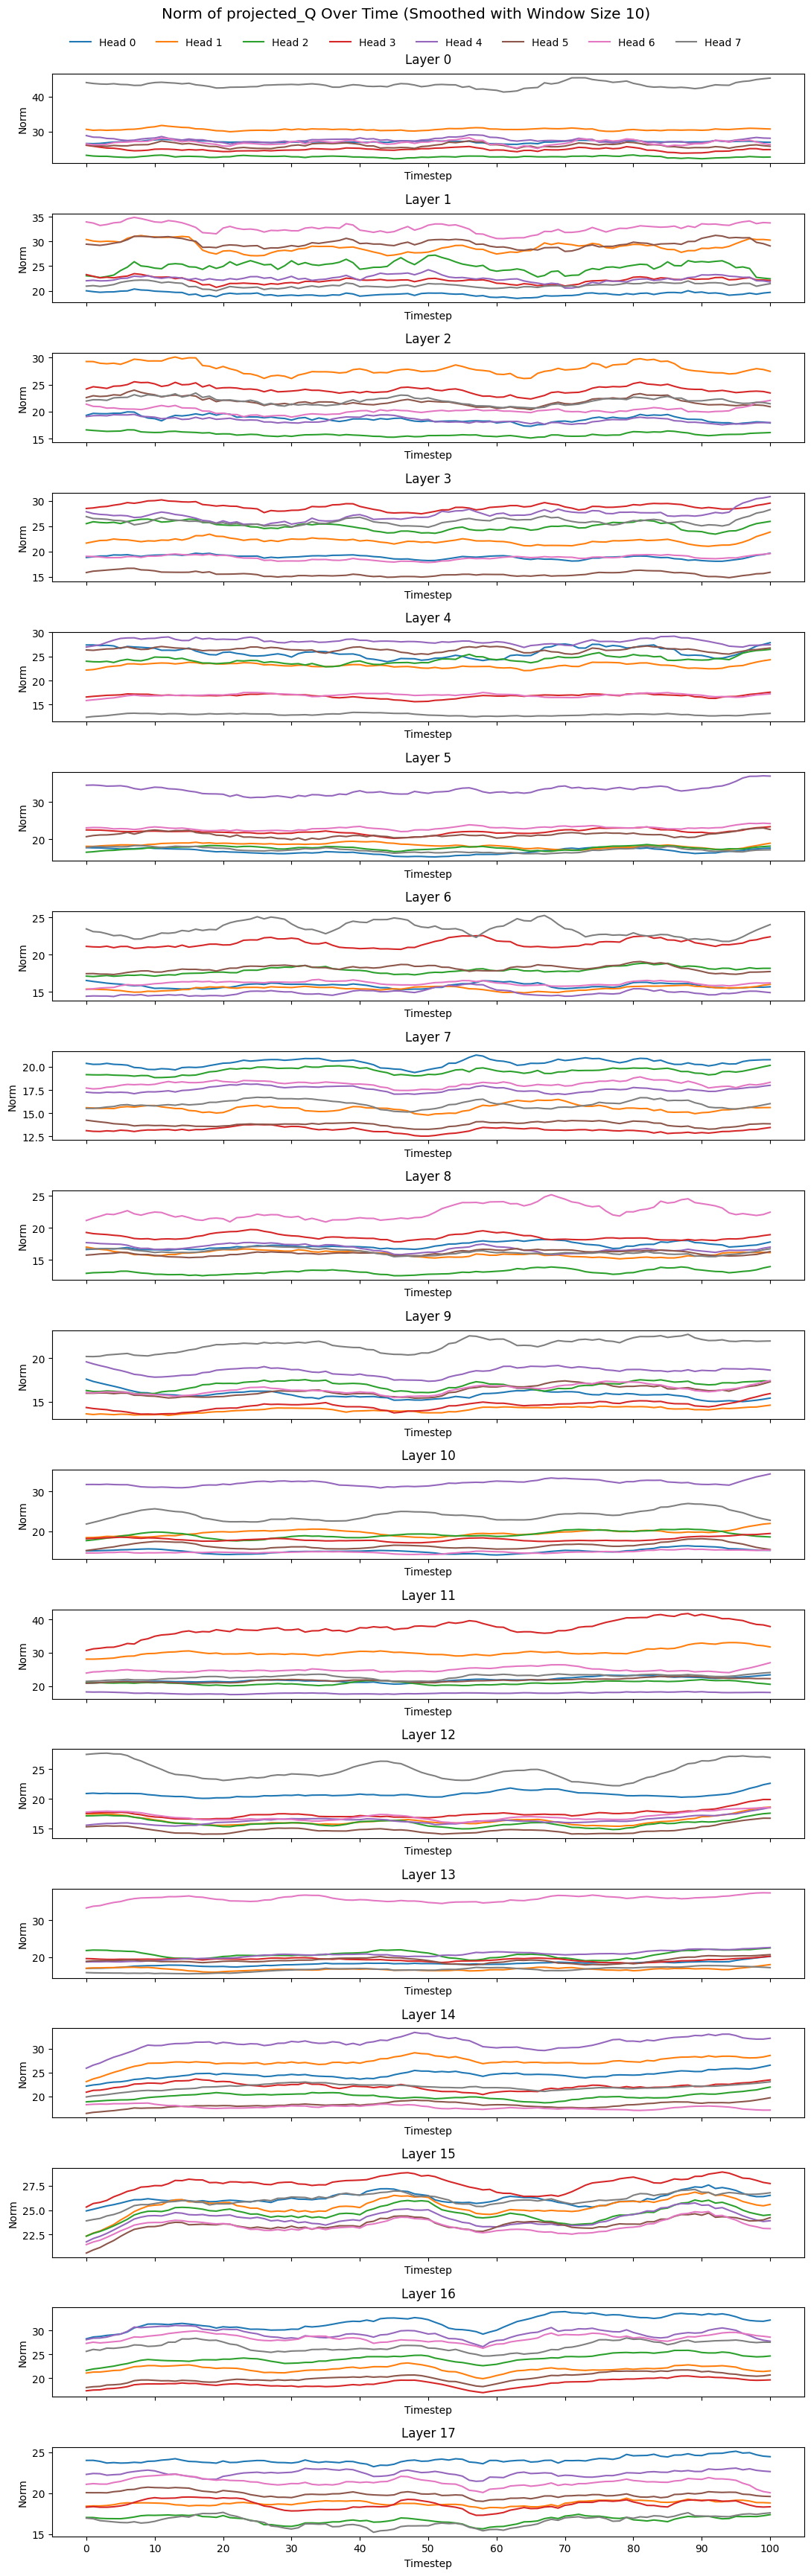

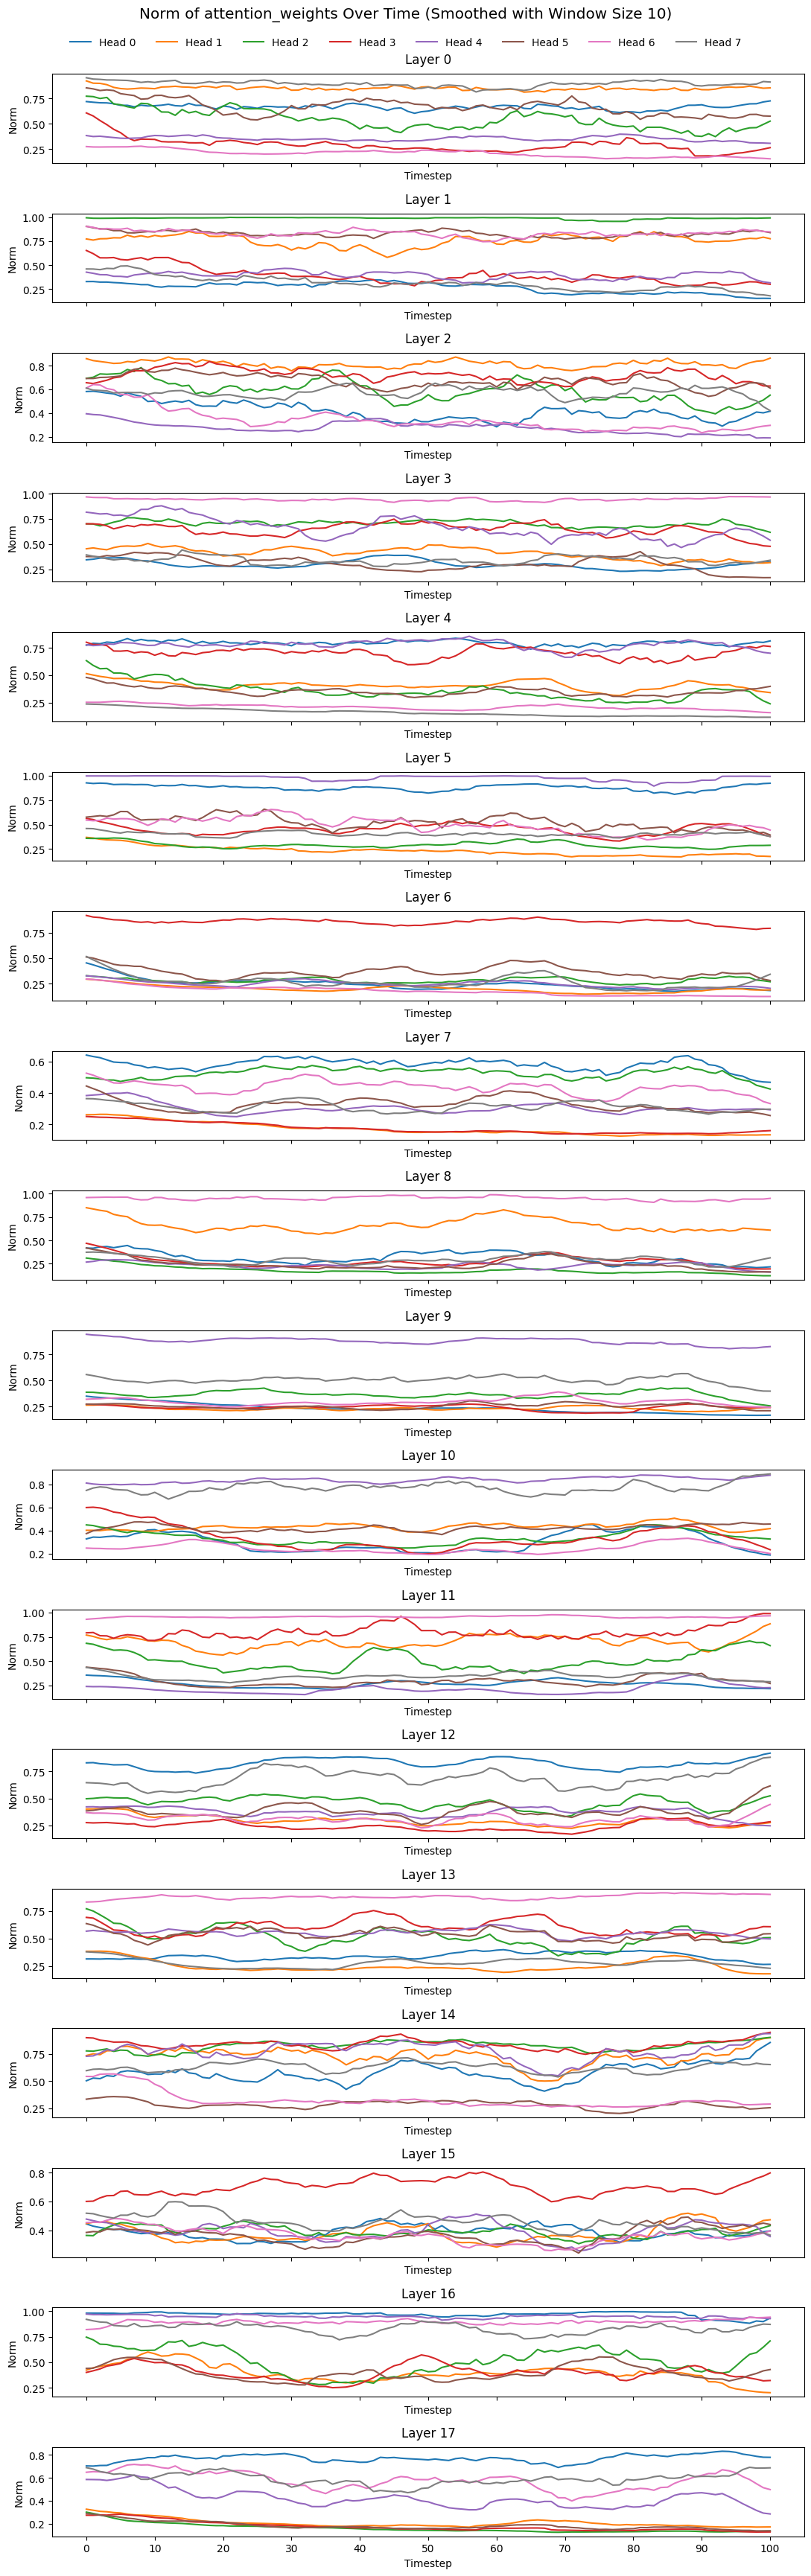

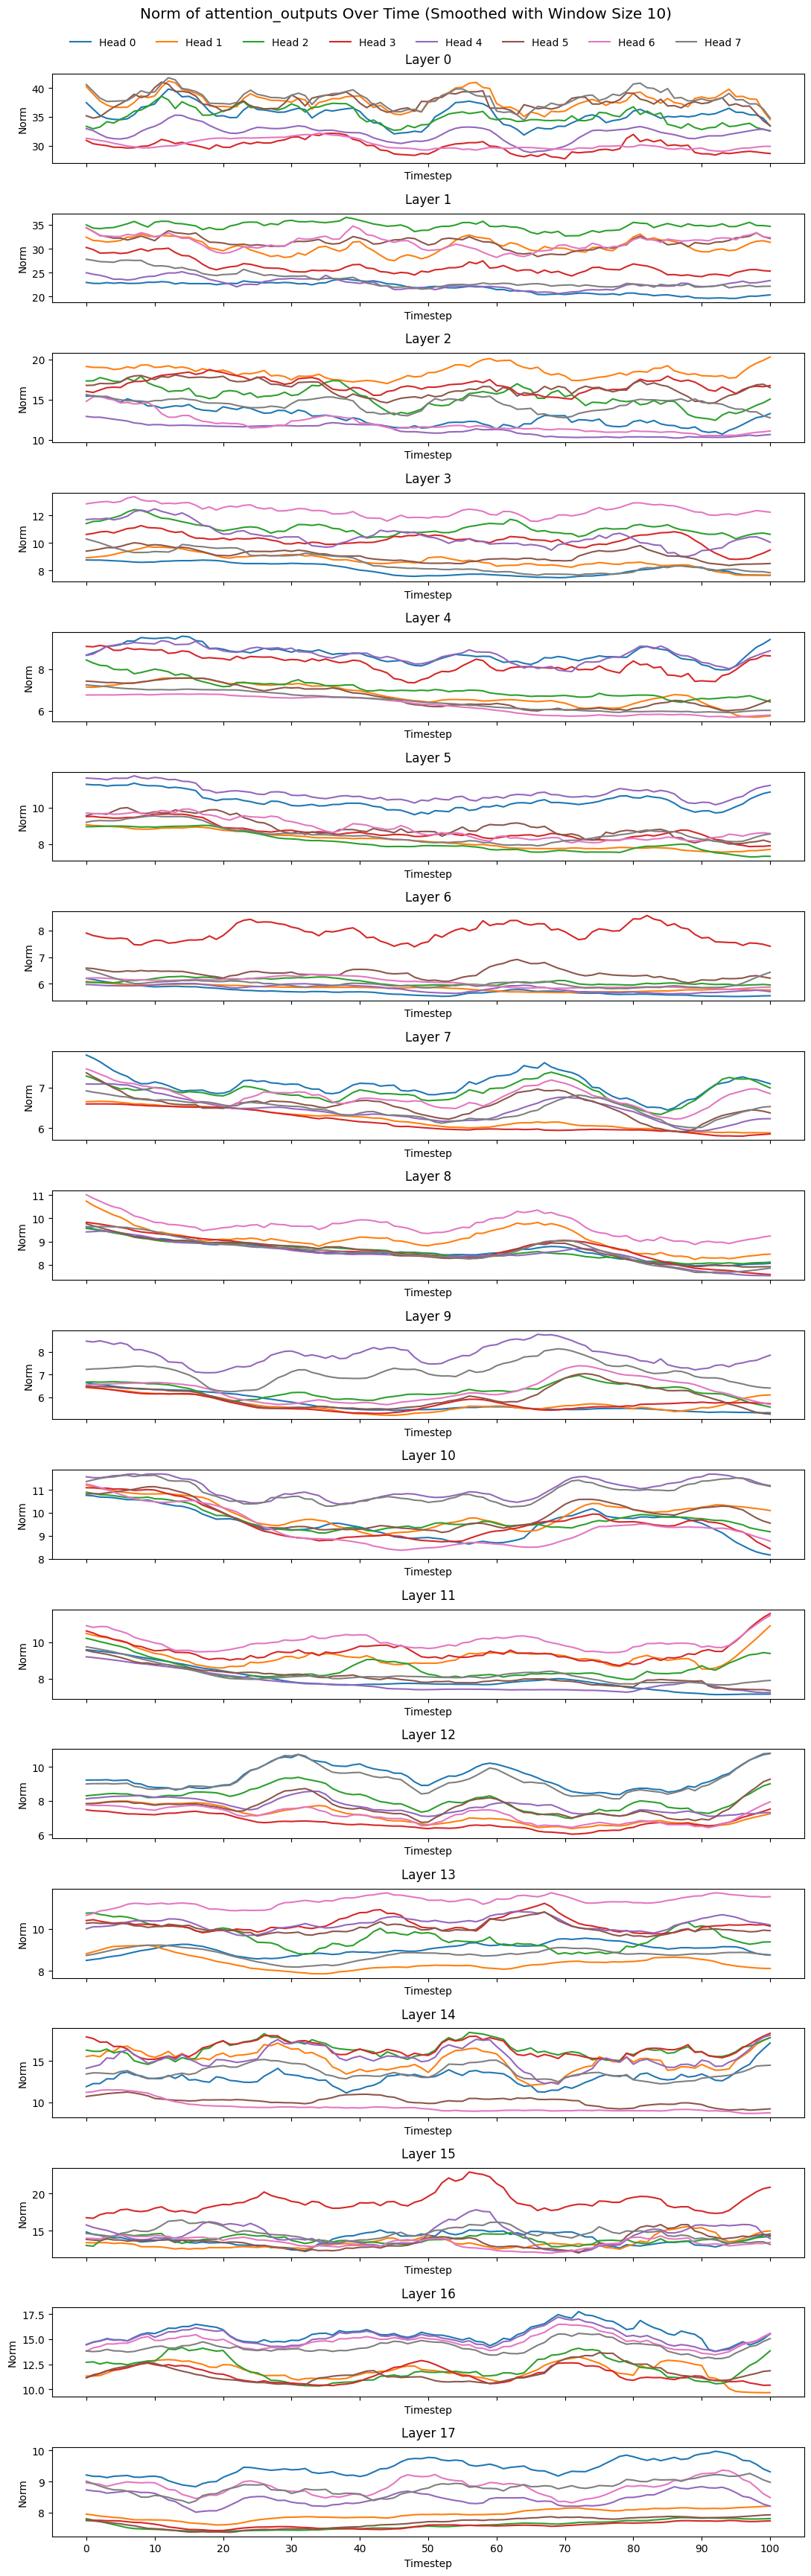

In [10]:
time_series = load_time_series(0) # Load the time series for the first 1000 tokens, choose from 0 to 4

short_time_series = False 
# Shorten the time series 
if short_time_series:
    for attention_metric in constants.METRICS_TRANSFORMER:
        for i in range(len(time_series[attention_metric])):
            for j in range(len(time_series[attention_metric][i])):
                time_series[attention_metric][i][j] = time_series[attention_metric][i][j][:100]

plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER , num_heads_plot=8, smoothing_window=10, save=False)

## Redundancy and Synergy Heatmaps

In [11]:
global_matrices, synergy_matrices, redundancy_matrices = compute_PhiID(time_series, metrics=constants.METRICS_TRANSFORMER )
# plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices)
# plot_all_PhiID(global_matrices)

## Graph Connetivity

In [12]:
compare_synergy_redundancy(synergy_matrices, redundancy_matrices, constants.METRICS_TRANSFORMER, verbose=False)

({'projected_Q': {'Synergy': 0.08534599609110423,
   'Redundancy': 0.044679017167474,
   'Synergy > Redundancy': True},
  'attention_weights': {'Synergy': 0.07328899485585866,
   'Redundancy': 0.025558421761264574,
   'Synergy > Redundancy': True},
  'attention_outputs': {'Synergy': 0.10390088672742172,
   'Redundancy': 0.05624858738688571,
   'Synergy > Redundancy': True}},
 {'projected_Q': {'Synergy': 0.11346567138160085,
   'Redundancy': 0.2724604137288684,
   'Redundancy > Synergy': True},
  'attention_weights': {'Synergy': 0.11709556205103072,
   'Redundancy': 0.23450872497273512,
   'Redundancy > Synergy': True},
  'attention_outputs': {'Synergy': 0.10846595510673174,
   'Redundancy': 0.16880746818491887,
   'Redundancy > Synergy': True}})

## Measuring Head Activation

In [37]:
def compute_and_plot_attention_heatmap(time_series_attention_weights, plot_heatmap=True, top_percentage=25):
    # Convert to numpy array for easier manipulation
    time_series_np = np.array(time_series_attention_weights)
    time_series_np = np.squeeze(time_series_np, axis=-1)

    # Compute the average across time (last dimension)
    average_attention = np.mean(time_series_np, axis=2)

    if plot_heatmap:
        plt.figure(figsize=(8, 5))
        ax = sns.heatmap(average_attention, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
                         linewidths=0.5, linecolor='gray', cbar_kws={"shrink": 0.8, "label": 'Average Attention Weight'})
        ax.set_xticklabels([f"Layer {i+1}" for i in range(average_attention.shape[1])], rotation=45, ha="right")
        ax.set_yticklabels([f"Head {i+1}" for i in range(average_attention.shape[0])], rotation=0)
        plt.title("Average Attention Weights Norm Across Time", pad=20)
        plt.xlabel("Layer", labelpad=10)
        plt.ylabel("Head", labelpad=10)
        plt.tight_layout()
        plt.show()

    # Flatten the average_attention array to rank heads across all layers
    flattened_attention = average_attention.flatten()

    # Determine the number of heads to select based on the top_percentage
    num_heads_to_select = int(len(flattened_attention) * (top_percentage / 100.0))

    # Get the indices of the top activated heads in descending order of activation
    top_head_indices = np.argsort(flattened_attention)[-num_heads_to_select:][::-1]

    # Convert flat indices back to layer and head indices, in order from most to least activated
    top_heads = [(index // average_attention.shape[1], index % average_attention.shape[1]) for index in top_head_indices]

    return average_attention, top_heads

In [41]:
top_percentage = 5
for i in range(5):
    time_series = load_time_series(i)  # Load the time series for the ith example
    time_series_attention_weights = time_series["attention_weights"]
    _, top_heads = compute_and_plot_attention_heatmap(time_series_attention_weights, plot_heatmap=False, top_percentage=top_percentage)
    print(f"Top {top_percentage}% activated heads for series {i}: {top_heads}")

Top 5% activated heads for series 0: [(1, 2), (3, 6), (0, 7), (14, 3), (10, 4), (11, 6), (13, 6)]
Top 5% activated heads for series 1: [(1, 2), (3, 6), (14, 3), (10, 4), (0, 7), (11, 6), (13, 6)]
Top 5% activated heads for series 2: [(1, 2), (3, 6), (14, 3), (10, 4), (0, 7), (11, 6), (13, 6)]
Top 5% activated heads for series 3: [(1, 2), (3, 6), (11, 6), (14, 3), (0, 7), (10, 4), (13, 6)]
Top 5% activated heads for series 4: [(1, 2), (3, 6), (14, 3), (10, 4), (0, 7), (13, 6), (11, 6)]
